In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

### Reading & Processing Images

In [2]:
p = Path('./images/')

In [3]:
print(p, type(p))

images <class 'pathlib.PosixPath'>


In [4]:
dirs = p.glob('*')

In [5]:
labels_dict = {
    'cat': 0,
    'dog': 1,
    'horse': 2,
    'human': 3
}

In [6]:
image_data, labels = [], []

for folder_name in dirs :

    label = str(folder_name).split("/")[-1][:-1]
    print(label)
    
    for img_path in folder_name.glob('*.jpg') :
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

horse
cat
dog
human


In [7]:
print(len(image_data), len(labels))

808 808


In [8]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

In [9]:
print(image_data.shape, labels.shape)

(808, 32, 32, 3) (808,)


### Randomly shuffle data

In [10]:
import random

combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

### Visualise data

In [11]:
def drawImg(img) :
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

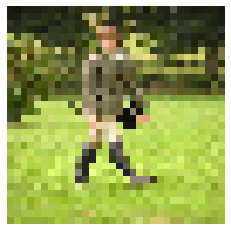

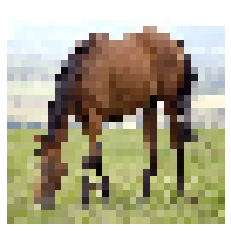

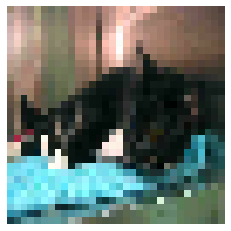

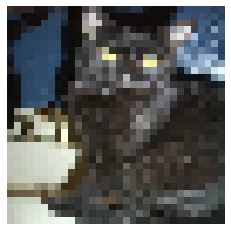

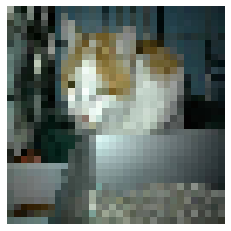

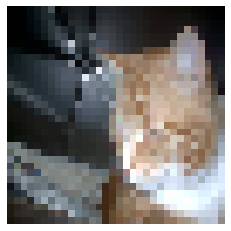

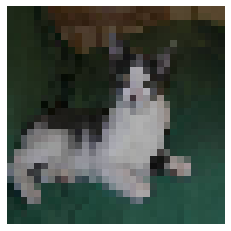

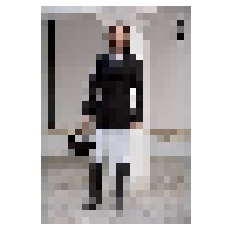

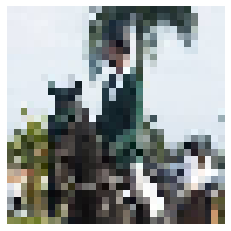

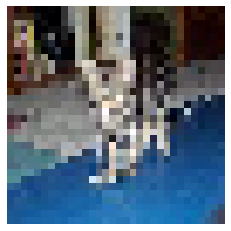

In [12]:
for i in range (10) :
    drawImg(image_data[i])

### SVM classifier

In [13]:
class SVM :
    
    def __init__(self, C=1) : # C is penalty for outliers
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self, W, b, X, Y) :
        loss = 0.0
        
        loss += .5 * np.dot(W, W.T)
        
        m = X.shape[0]
        
        for i in range(m) :
            ti = Y[i] * (np.dot(W, X[i].T) + b) # W->1 x n, X[i]->1 x n
            loss += self.C * max(0, (1 - ti))
            
        return loss[0][0]
    
    def fit(self, X, Y, batch_size=100, learning_rate=0.001, maxItr=500) :
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        # Initialise model parameters
        W = np.zeros((1, no_of_features))
        bias = 0
        
        # Initial loss
        # print(self.hingeLoss(W, bias, X, Y))
        
        # Training starts from here, update weight and bias
        losses = []
        
        for i in range(maxItr) :
            
            l = self.hingeLoss(W, bias, X, Y)
            losses.append(l)
            
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            # Batch Gradient Descent with random shuffling
            for batch_start in range(0, no_of_samples, batch_size) :
                # Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                # Iterate over all examples in mini batch
                for j in range(batch_start, batch_start + batch_size) :
                    if j < no_of_samples :
                        i = ids[j]
                        ti = Y[i] * (np.dot(W, X[i].T) + bias)
                        
                        if ti > 1 :
                            gradw += 0
                            gradb += 0
                        else :
                            gradw += c * Y[i] * X[i]
                            gradb += c * Y[i]
                    
                W = W - n * W + n * gradw
                bias = bias + n * gradb
                
        self.W = W
        self.b = bias
        return W, bias, losses

### Preprocess data for one-vs-one

In [14]:
M = image_data.shape[0]
image_data = image_data.reshape(M, -1)
print(image_data.shape, labels.shape)

(808, 3072) (808,)


In [15]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [16]:
def classWiseData(x, y) :
    data = {}
    for i in range(CLASSES) :
        data[i] = []
    
    for i in range(x.shape[0]) :
        data[y[i]].append(x[i])
        
    for k in data.keys() :
        data[k] = np.array(data[k])
    
    return data

In [17]:
data = classWiseData(image_data, labels)

In [18]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])
print(data[0].shape)

202
202
202
202
(202, 3072)


In [19]:
def getDataPairForSVM(d1, d2) :
    
    l1, l2 = d1.shape[0], d2.shape[0]
    
    samples = l1 + l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples, ))
    
    data_pair[:l1, :] = d1
    data_pair[l1:, :] = d2
    data_labels[:l1] = -1 # 0 for logistic regression
    data_labels[l1:] = +1
    
    return data_pair, data_labels

### Training SVM

In [20]:
mySVM = SVM()

In [41]:
def trainSVMs(x, y) :
    svm_classifiers = {}
    
    for i in range(CLASSES) :
        svm_classifiers[i] = {}
        for j in range(i + 1, CLASSES) :
            xpair, ypair = getDataPairForSVM(data[i], data[j])
            wts, b, loss = mySVM.fit(xpair, ypair, learning_rate = 0.00001, maxItr=1500)
            svm_classifiers[i][j] = (wts, b)
            
    return svm_classifiers

In [42]:
svm_classifiers = trainSVMs(image_data, labels)

In [43]:
cats_horses = svm_classifiers[0][2]
print(cats_horses[0], cats_horses[1])

[[0.00084367 0.02533353 0.03528086 ... 0.04319161 0.04460399 0.02519903]] -0.10154000000000023


### Predictions

In [44]:
def binaryPredict(x, w, b) :
    z = np.dot(x, w.T) + b
    if z >= 0 :
        return 1
    else :
        return -1

In [45]:
def predict(x) :
    count = np.zeros((CLASSES, ))
    
    for i in range(CLASSES) :
        for j in range(i + 1, CLASSES) :
            w, b = svm_classifiers[i][j]
            
            # Take majority prediction for each classifier
            z = binaryPredict(x, w, b)
            
            if z == 1 :
                count[j] += 1
            else :
                count[i] += 1
                
    final_prediction = np.argmax(count)
    return final_prediction

In [46]:
print(predict(image_data[4]), labels[4])

0 0


In [47]:
def accuracy(x, y) :
    count = 0
    m = x.shape[0]
    
    for i in range(m) :
        prediction = predict(x[i])
        if prediction == y[i] :
            count += 1
    
    return count / m * 100

In [48]:
print(accuracy(image_data, labels))

63.49009900990099


In [37]:
from sklearn import svm

In [38]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)

In [39]:
svm_classifier.fit(image_data, labels)

SVC(kernel='linear')

In [40]:
print(svm_classifier.score(image_data, labels))

0.6707920792079208
